<a href="https://colab.research.google.com/github/ahmedhisham73/AI_in_healthcare/blob/main/monai_end_to_end_workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -qU "monai[ignite, nibabel, torchvision, tqdm]==0.6.0"

     |████████████████████████████████| 584 kB 4.1 MB/s 
     |████████████████████████████████| 221 kB 74.0 MB/s 


In [2]:
!nvidia-smi

Thu Dec  9 13:28:43 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import numpy as np
import PIL

import torch
import monai

from monai.apps import download_and_extract
from monai.config import print_config
from monai.metrics import ROCAUCMetric
from monai.data import decollate_batch, partition_dataset_classes
from monai.networks.nets import DenseNet121
from monai.transforms import (
    AddChannel,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
    ToTensor,
    Activations,
    AsDiscrete,
    EnsureType
)
from monai.utils import set_determinism

In [4]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmp_hkm7vxo


In [5]:
resource = "https://www.dropbox.com/s/5wwskxctvcxiuea/MedNIST.tar.gz?dl=1"
md5 = "0bc7306e7427e00ad1c5526a6677552d"

compressed_file = os.path.join(root_dir, "MedNIST.tar.gz")
data_dir = os.path.join(root_dir, "MedNIST")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)

MedNIST.tar.gz: 59.0MB [00:06, 9.65MB/s]                            


Downloaded: /tmp/tmp_hkm7vxo/MedNIST.tar.gz
Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
Writing into directory: /tmp/tmp_hkm7vxo.


In [6]:
set_determinism(seed=0)

In [7]:
class_names = sorted(x for x in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, x)))
num_class = len(class_names)

image_files = [
    [
        os.path.join(data_dir, class_names[i], x)
        for x in os.listdir(os.path.join(data_dir, class_names[i]))
    ]
    for i in range(num_class)
]

num_each = [len(image_files[i]) for i in range(num_class)]
image_files_list = []
image_class = []

for i in range(num_class):
    image_files_list.extend(image_files[i])
    image_class.extend([i] * num_each[i])
    
num_total = len(image_class)
image_width, image_height = PIL.Image.open(image_files_list[0]).size

print(f"Total image count: {num_total}")
print(f"Image dimensions: {image_width} x {image_height}")
print(f"Label names: {class_names}")
print(f"Label counts: {num_each}")


Total image count: 58954
Image dimensions: 64 x 64
Label names: ['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT']
Label counts: [10000, 8954, 10000, 10000, 10000, 10000]


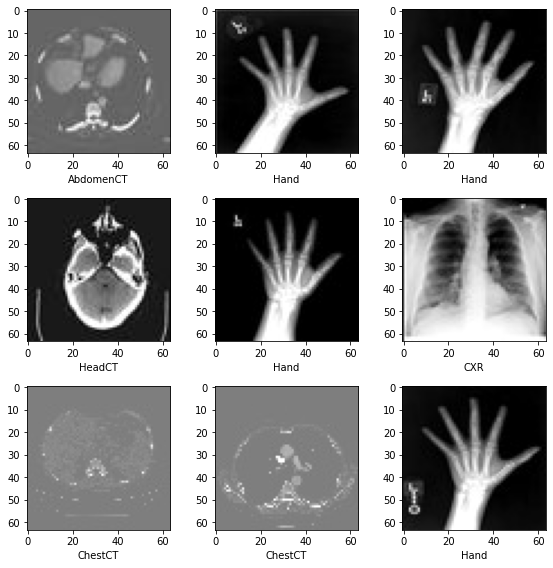

In [8]:
plt.subplots(3, 3, figsize=(8, 8))
for i, k in enumerate(np.random.randint(num_total, size=9)):
    im = PIL.Image.open(image_files_list[k])
    arr = np.array(im)
    plt.subplot(3, 3, i + 1)
    plt.xlabel(class_names[image_class[k]])
    plt.imshow(arr, cmap="gray", vmin=0, vmax=255)
plt.tight_layout()
plt.show()

In [10]:
train_inds, val_inds, test_inds = partition_dataset_classes(np.arange(len(image_files_list)), 
                                                            image_class,(80, 10, 10), shuffle=True)

train_x = [image_files_list[i] for i in train_inds]
train_y = [image_class[i] for i in train_inds]
val_x = [image_files_list[i] for i in val_inds]
val_y = [image_class[i] for i in val_inds]
test_x = [image_files_list[i] for i in test_inds]
test_y = [image_class[i] for i in test_inds]

print(f"Training count: {len(train_x)}, Validation count: {len(val_x)}, Test count: {len(test_x)}")

Training count: 47163, Validation count: 5895, Test count: 5895


In [11]:
train_transforms = Compose(
    [
        LoadImage(image_only=True),
        AddChannel(),
        ScaleIntensity(),
        RandRotate(range_x=15, prob=0.5, keep_size=True),
        RandFlip(spatial_axis=0, prob=0.5),
        RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
        ToTensor(),
    ]
)

val_transforms = Compose([LoadImage(image_only=True), AddChannel(), ScaleIntensity(), ToTensor()])

act = Compose([EnsureType(), Activations(softmax=True)])
to_onehot = Compose([EnsureType(), AsDiscrete(to_onehot=True, n_classes=num_class)])

In [12]:
batch_size = 512
num_workers = 10

class MedNISTDataset(torch.utils.data.Dataset):
    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        return self.transforms(self.image_files[index]), self.labels[index]


train_ds = MedNISTDataset(train_x, train_y, train_transforms)
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers)

val_ds = MedNISTDataset(val_x, val_y, val_transforms)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=batch_size, num_workers=num_workers)

test_ds = MedNISTDataset(test_x, test_y, val_transforms)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=batch_size, num_workers=num_workers)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [13]:
learning_rate = 1e-5
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = DenseNet121(spatial_dims=2, in_channels=1, out_channels=num_class).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), learning_rate)

In [14]:
epoch_num = 4
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = list()
metric_values = list()
auc_metric = ROCAUCMetric()

for epoch in range(epoch_num):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{epoch_num}")

    epoch_loss = 0
    step = 1

    steps_per_epoch = len(train_ds) // train_loader.batch_size

    # put the network in train mode; this tells the network and its modules to
    # enable training elements such as normalisation and dropout, where applicable
    net.train()
    for batch_data in train_loader:

        # move the data to the GPU
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)

        # prepare the gradients for this step's back propagation
        optimizer.zero_grad()
        
        # run the network forwards
        outputs = net(inputs)
        
        # run the loss function on the outputs
        loss = loss_function(outputs, labels)
        
        # compute the gradients
        loss.backward()
        
        # tell the optimizer to update the weights according to the gradients
        # and its internal optimisation strategy
        optimizer.step()

        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size + 1}, training_loss: {loss.item():.4f}")
        step += 1

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    # after each epoch, run our metrics to evaluate it, and, if they are an improvement,
    # save the model out
    
    # switch off training features of the network for this pass
    net.eval()

    # 'with torch.no_grad()' switches off gradient calculation for the scope of its context
    with torch.no_grad():
        # create lists to which we will concatenate the the validation results
        preds = list()
        labels = list()

        # iterate over each batch of images and run them through the network in evaluation mode
        for val_data in val_loader:
            val_images, val_labels = val_data[0].to(device), val_data[1].to(device)

            # run the network
            val_pred = net(val_images)

            preds.append(val_pred)
            labels.append(val_labels)

        # concatenate the predicted labels with each other and the actual labels with each other
        y_pred = torch.cat(preds)
        y = torch.cat(labels)

        # we are using the area under the receiver operating characteristic (ROC) curve to determine
        # whether this epoch has improved the best performance of the network so far, in which case
        # we save the network in this state
        y_onehot = [to_onehot(i) for i in decollate_batch(y)]        
        y_pred_act = [act(i) for i in decollate_batch(y_pred)]
        
        auc_metric(y_pred_act, y_onehot)
        auc_value = auc_metric.aggregate()
        auc_metric.reset()
        metric_values.append(auc_value)
        
        acc_value = torch.eq(y_pred.argmax(dim=1), y)
        acc_metric = acc_value.sum().item() / len(acc_value)
        
        if auc_value > best_metric:
            best_metric = auc_value
            best_metric_epoch = epoch + 1
            torch.save(net.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
            print("saved new best metric network")
            
        print(
            f"current epoch: {epoch + 1} current AUC: {auc_value:.4f} /"
            f" current accuracy: {acc_metric:.4f} best AUC: {best_metric:.4f} /"
            f" at epoch: {best_metric_epoch}"
        )

print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}")

----------
epoch 1/4


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


1/93, training_loss: 1.7700
2/93, training_loss: 1.7658
3/93, training_loss: 1.7299
4/93, training_loss: 1.7177
5/93, training_loss: 1.6830
6/93, training_loss: 1.6622
7/93, training_loss: 1.6531
8/93, training_loss: 1.6289
9/93, training_loss: 1.6108
10/93, training_loss: 1.5784
11/93, training_loss: 1.5607
12/93, training_loss: 1.5430
13/93, training_loss: 1.5254
14/93, training_loss: 1.4918
15/93, training_loss: 1.4724
16/93, training_loss: 1.4550
17/93, training_loss: 1.4315
18/93, training_loss: 1.4205
19/93, training_loss: 1.3929
20/93, training_loss: 1.3746
21/93, training_loss: 1.3692
22/93, training_loss: 1.3522
23/93, training_loss: 1.3465
24/93, training_loss: 1.3156
25/93, training_loss: 1.2797
26/93, training_loss: 1.2762
27/93, training_loss: 1.2673
28/93, training_loss: 1.2269
29/93, training_loss: 1.2150
30/93, training_loss: 1.2011
31/93, training_loss: 1.2118
32/93, training_loss: 1.1698
33/93, training_loss: 1.1916
34/93, training_loss: 1.1453
35/93, training_loss: 1

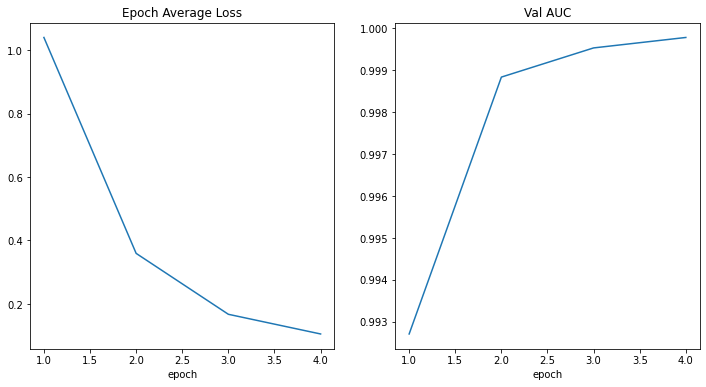

In [15]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val AUC")
x = [(i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

In [16]:
rseed = 12345678

train_transforms = Compose(
    [
        LoadImage(image_only=True),
        AddChannel(),
        ScaleIntensity(),
        RandRotate(range_x=15, prob=0.5, keep_size=True).set_random_state(rseed),
        RandFlip(spatial_axis=0, prob=0.5).set_random_state(rseed),
        RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5).set_random_state(rseed),
        ToTensor(),
    ]
)

val_transforms = Compose([LoadImage(image_only=True), AddChannel(), ScaleIntensity(), ToTensor()])

In [17]:
parts = partition_dataset_classes(
    data=np.arange(len(image_files_list)), 
    classes=image_class, 
    ratios=(8, 1, 1), 
    shuffle=True, 
    seed=rseed
)

image_sets = [list(), list(), list()]
label_sets = [list(), list(), list()]

for i, part in enumerate(parts):
    image_sets[i] = [image_files_list[idx] for idx in part]
    label_sets[i] = [image_class[idx] for idx in part]

train_x, val_x, test_x = image_sets
train_y, val_y, test_y = label_sets
print(len(train_x), len(val_x), len(test_x))

47163 5895 5895
